In [2]:
import numpy as np
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

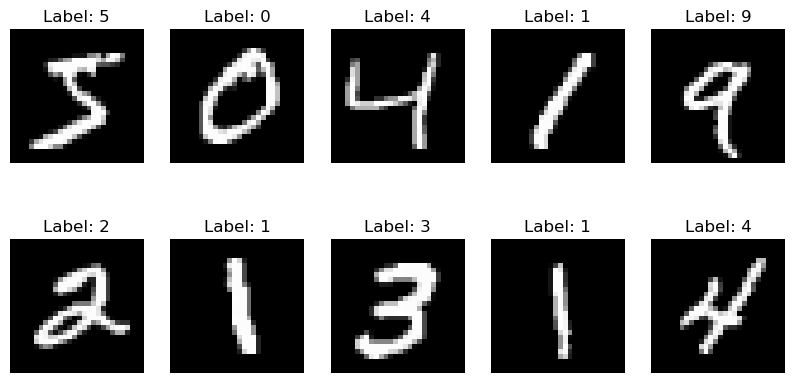

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")

Looking at how the MNIST data looks - useful for later when we build the streamlit application and want to see brush thickness etc. to match.

Text(0.5, 1.0, 'Number Distribution')

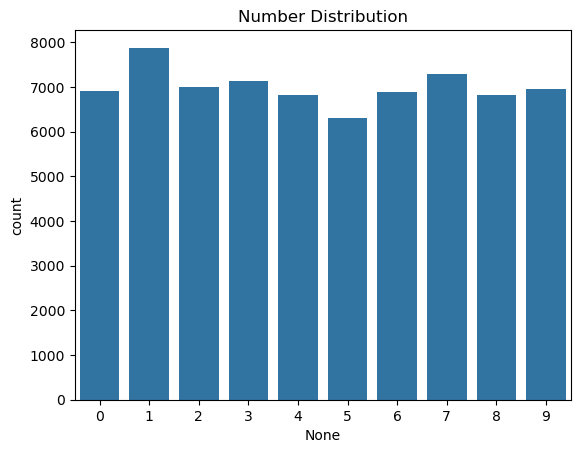

In [5]:
import seaborn as sns
import pandas as pd

sns.countplot(x=pd.Series(y))
plt.title("Number Distribution")

Small variation in distribution of numbers within the dataset - smallest number is 5, largest 1. 

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

print("X_train_val size:", X_train_val.shape)
print("X_test size:", X_test.shape)
print("y_train_val size:", y_train_val.shape)
print("y_test size:", y_test.shape)

print("X_train size:", X_train.shape)
print("X_val size:", X_val.shape)
print("y_train size:", y_train.shape)
print("y_val size:", y_val.shape)

X_train_val size: (60000, 784)
X_test size: (10000, 784)
y_train_val size: (60000,)
y_test size: (10000,)
X_train size: (50000, 784)
X_val size: (10000, 784)
y_train size: (50000,)
y_val size: (10000,)


Looks correct for the x train/test/split sizes.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

log_reg = LogisticRegression(solver="lbfgs", max_iter=100, multi_class="multinomial", n_jobs=-1)

log_reg.fit(X_train_scaled, y_train)

c:\Users\micha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', n_jobs=-1)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

#Confusion matrix 
cm = confusion_matrix(y_train, y_train_pred)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_train, y_train_pred))

We can see that with this logistic regression model that the model struggles most with 3, 5, 8 and 9. Overall accuracy was reasonably though - 94%, but this can almost certainly be improved upon. We could look to either adjust the hyperparameters of this model or perhaps look at better models for the task at hand. 

In [13]:
from sklearn.model_selection import GridSearchCV

The below gridsearch was ran and the ideal hyperparameters chosen. 

In [18]:
#Here is where we should properly run our GridSearchCV - then find ideal hyperparameters for the model, THEN TRAIN ON TEST.
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "saga"],
    "max_iter": [1000],
    "random_state": [42],
}

log_reg = LogisticRegression(multi_class="multinomial", n_jobs=-1)

grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

y_train_val_augmented = []

# First time I've ever touched image augmentation - these are some light augmentations that I settled on because logistic regression might have a hard time with heavier augmentation.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

for i, image in enumerate(X_train_val):
    image = image.flatten()
    pil_image = Image.fromarray(image.reshape(28, 28).astype(np.uint8))
    
    # Needs to be a np array to run the augmentation, and also requires 4 dimensions.
    pil_image_np = np.array(pil_image).reshape((1, 28, 28, 1))
    augmented_images = datagen.flow(pil_image_np, batch_size=1)
    for aug_img in augmented_images:
        
        y_train_val_augmented.append(aug_img[0].flatten())
        
        #Included to stop loop issue
        break

X_train_val_augmented = np.array(y_train_val_augmented)

scaler = MinMaxScaler()

X_train_val_scaled = X_train_val_augmented / 255.0
X_test_scaled = X_test / 255.0

log_reg_best = LogisticRegression(C=1, solver='saga', max_iter=1000, random_state=42)
log_reg_best.fit(X_train_val_scaled, y_train_val)

y_pred = log_reg_best.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.8169
Confusion Matrix:
[[ 916    6    5    1    9   10    8    5   10   13]
 [   0 1117    4    8    0    6    2    0   11    4]
 [   6   35  793    8   26    7   28   14   43    7]
 [   6   53   36  806    8   45    5   23   31   21]
 [   3   28    2    0  779    0   16    3    4   71]
 [  14   63    7   60   48  611   49   16   54   15]
 [  13   62    7    0   31   10  828    2    7    1]
 [   2   46   12    2   19    4    2  860    5  103]
 [  19  107   13   37   29   34   31   14  639   46]
 [  12   63    3    6   66    3    4   38   21  820]]


c:\Users\micha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The above code ran for about 2hrs 20 minutes to completion and did not converge, but I expect that the converged accuracy is not much higher than the given 81.69%. I am quite confident that earlier models trained on un-augmentated imagery are actually just over-fitted to predict MNIST data, and poorly adapted to predicting inputted data in the Streamlit application. This led to accuracy closer to 40% in real-life testing, whereas this model I believe performs better than the previous model in real-world testing but evidently performs worse on the MNIST test data. In that regard, the model still over-fits somewhat, but is more better aligned to predict real-world data than previously, which the MNIST dataset attempts to emulate. 

I believe that it is generally an issue of logistic regression being poorly suited to predicting the MNIST data, but I also believe that the model I have built above actually does an okay (60%~) job of predicting real-world data, which is a marked improvement and suggests we counter-acted some of the overfitting in the original model.

In [62]:
import joblib

joblib.dump(log_reg_best, 'log_reg_model_aug.pkl')

['log_reg_model_aug.pkl']

Test Accuracy: 0.8168


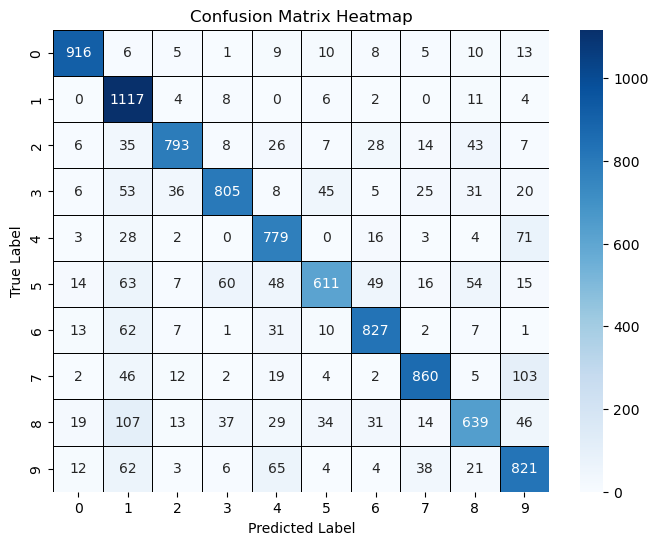

In [17]:
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix

X_test_scaled = scaler.transform(X_test)

log_reg_best = joblib.load("log_reg_model_aug.pkl")

y_pred = log_reg_best.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

This confusion matrix tells us a bit of information - that it over-predicts 1, and struggles to distinguish between 9, 7, and 4. 

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       983
           1       0.71      0.97      0.82      1152
           2       0.90      0.82      0.86       967
           3       0.87      0.78      0.82      1034
           4       0.77      0.86      0.81       906
           5       0.84      0.65      0.73       937
           6       0.85      0.86      0.86       961
           7       0.88      0.82      0.85      1055
           8       0.77      0.66      0.71       969
           9       0.75      0.79      0.77      1036

    accuracy                           0.82     10000
   macro avg       0.83      0.81      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Here we can see that there are a lot of false positives for some values, such as 1, 4, 8 and 9. Comparatively, the true positive rate for 1 is very high. This means that our model generally over-predicts 1, and struggles greatly with certain other numbers, such as 5 (65% true positive) and 8 (66% true positive). This is interesting information and really shows the weaknesses of the logistic regression model for this task. All in all, the f1 score can give a good combined metric for this - and shows that the model is best at identifying 0, 2, 6 and 7 (all above 0.85 f1 score). 

So after some changes I believe that this model has the proper format in terms of train/validation/test, with no issues of the test being used to train. 

After a bit of research it appears that the best model to accurately predict the MNIST data is by using a CNN (Convolutional neural network) model. Maybe I should try an intermediary model first though? Random forest?

In [19]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_val_flat = X_train_val.reshape(X_train_val.shape[0], -1)


Flattening the data - as Random Forest is not able to manage 2D imaging. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

Trained it in 18.5s. 

Now to see the results:

In [21]:
train_acc = rf_clf.score(X_train_flat, y_train)

print(f"Train Accuracy: {train_acc:.4f}")

Train Accuracy: 1.0000


100% training accuracy?

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': np.arange(100, 301, 50),
    'max_depth': np.arange(10, 51, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, 
                                   n_iter=20, cv=3, scoring='accuracy', 
                                   verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train_flat, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}
Best Validation Accuracy: 0.9657600295731994


In [23]:
rf_clf_best = RandomForestClassifier(n_estimators=200, min_samples_split=2, 
                                     min_samples_leaf=1, max_depth=40, random_state=42)

rf_clf_best.fit(X_train_val_flat, y_train_val)

RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)

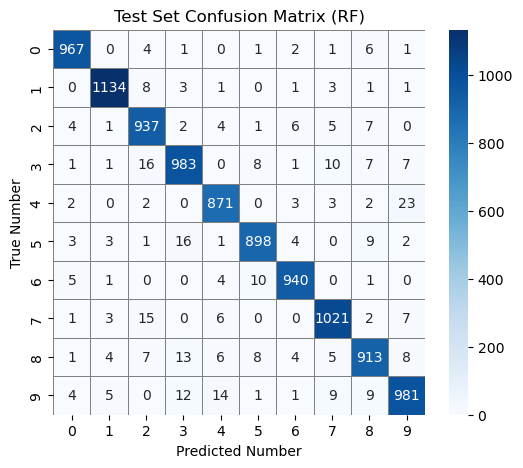

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_test_pred = rf_clf.predict(X_test_flat)

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='gray')

plt.title("Test Set Confusion Matrix (RF)")
plt.xlabel('Predicted Number')
plt.ylabel('True Number')

plt.show()

In [25]:
from sklearn.metrics import classification_report

In [30]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.8f}")

Test Set Accuracy: 0.96450000


In [ ]:
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       983
           1       0.98      0.98      0.98      1152
           2       0.95      0.97      0.96       967
           3       0.95      0.95      0.95      1034
           4       0.96      0.96      0.96       906
           5       0.97      0.96      0.96       937
           6       0.98      0.98      0.98       961
           7       0.97      0.97      0.97      1055
           8       0.95      0.94      0.95       969
           9       0.95      0.95      0.95      1036

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [27]:
import joblib

joblib.dump(rf_clf_best, 'rf_clf_final.pkl')

['rf_clf_final.pkl']

In [32]:
print(rf_clf_best.get_params()) 

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
from PIL import Image

num_samples = 10
mnist_samples = X_test[:num_samples].reshape(-1, 28, 28).astype(np.uint8)

for i, img_array in enumerate(mnist_samples):
    img = Image.fromarray(img_array)
    img.save(f"mnist_digit_{i}.png")

print("MNIST images saved successfully!")

MNIST images saved successfully!


Here I was troubleshooting why my RF model was not working in the streamlit app, so I pulled some real MNIST images to feed to the app and found that it was an issue with the preprocessing on the images that were being drawn on the app, as it performed as expected on pre-defined MNIST imaging. I fixed it by double checking my pre-processing steps. It now runs much better, but still below test-set expectations. 

Weaknesses in 3, 8 and 9 - but generally much stronger on average than the previous model.

TO DO TOMORROW: FINISH UP THIS MODEL WITH SUGGESTED HYPERPARAMETERS, THEN MOVE ON TO CNN MODEL AND IMPLEMENTING IT INTO THE WEBSITE. MAYBE INCLUDE THREE SEPARATE MODELS COMPARATIVELY ON THE WEBSITE? 

My plan now is to try a Deep Learning model in CNN. I read online that this is one of the best models for this kind of task. 

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [47]:
print(dir(tf.keras))

['DTypePolicy', 'FloatDTypePolicy', 'Function', 'Initializer', 'Input', 'InputSpec', 'KerasTensor', 'Layer', 'Loss', 'Metric', 'Model', 'Operation', 'Optimizer', 'Quantizer', 'Regularizer', 'RematScope', 'Sequential', 'StatelessScope', 'SymbolicScope', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'activations', 'applications', 'backend', 'callbacks', 'config', 'constraints', 'datasets', 'device', 'distribution', 'dtype_policies', 'export', 'initializers', 'layers', 'legacy', 'losses', 'metrics', 'mixed_precision', 'models', 'name_scope', 'ops', 'optimizers', 'preprocessing', 'quantizers', 'random', 'regularizers', 'remat', 'tree', 'utils', 'version', 'visualization', 'wrappers']


Reshaping data for CNN:

In [9]:
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

In [54]:
print(X_train_cnn.shape)

(50000, 28, 28, 1)


In [57]:
X_combined = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

print(X_combined.shape)

(60000, 28, 28, 1)


In [ ]:
cnn_model = keras.Sequential([
    input(shape=(28,28,1))
    layers.Conv2D(32, (3,3), activation='relu'),  
    layers.MaxPooling2D((2,2)),  
    layers.Conv2D(64, (3,3), activation='relu'),  
    layers.MaxPooling2D((2,2)),  
    layers.Flatten(),  
    layers.Dense(128, activation='relu'),  
    layers.Dense(10, activation='softmax')  
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_val_cnn, y_val))

test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10


c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8901 - loss: 1.3894 - val_accuracy: 0.9778 - val_loss: 0.0716
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9825 - loss: 0.0590 - val_accuracy: 0.9853 - val_loss: 0.0503
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9862 - loss: 0.0429 - val_accuracy: 0.9859 - val_loss: 0.0515
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9885 - loss: 0.0360 - val_accuracy: 0.9843 - val_loss: 0.0578
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9904 - loss: 0.0296 - val_accuracy: 0.9833 - val_loss: 0.0613
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9924 - loss: 0.0251 - val_accuracy: 0.9826 - val_loss: 0.0661
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9918 - loss: 0.0262 - val_accuracy: 0.9829 - val_loss: 0.0845
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9936 - loss: 0.0213 - val_accurac

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cnn_model_v2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_model_v2.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_combined)

cnn_model_v2.fit(datagen.flow(X_train_cnn, y_train, batch_size=32), 
                 epochs=20, 
                 validation_data=(X_val_cnn, y_val))


Epoch 1/20


c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\micha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8180 - loss: 1.3123 - val_accuracy: 0.9690 - val_loss: 0.1010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9628 - loss: 0.1196 - val_accuracy: 0.9834 - val_loss: 0.0563
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9730 - loss: 0.0886 - val_accuracy: 0.9830 - val_loss: 0.0573
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9744 - loss: 0.0842 - val_accuracy: 0.9858 - val_loss: 0.0489
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9756 - loss: 0.0781 - val_accuracy: 0.9880 - val_loss: 0.0509
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9798 - loss: 0.0672 - val_accuracy: 0.9845 - val_loss: 0.0545
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9788 - loss: 0.0684 - val_accuracy: 0.9851 - val_loss: 0.0547
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9823 - loss: 0.0593 - val_accurac

In [59]:
cnn_model_v2.save('cnn_model.v2.keras')

A small note here: I decided not to run hyperparameters on this model, instead moving straight to the test data. This is because I thought that the model performs very well already, and we are not yet at that point in the course where we are looking at DeepLearning models regardless.

Checking if model is corrupt below: 

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("cnn_model.keras")
model.summary()

c:\Users\micha\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,070 (1.72 MB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,036 (879.05 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


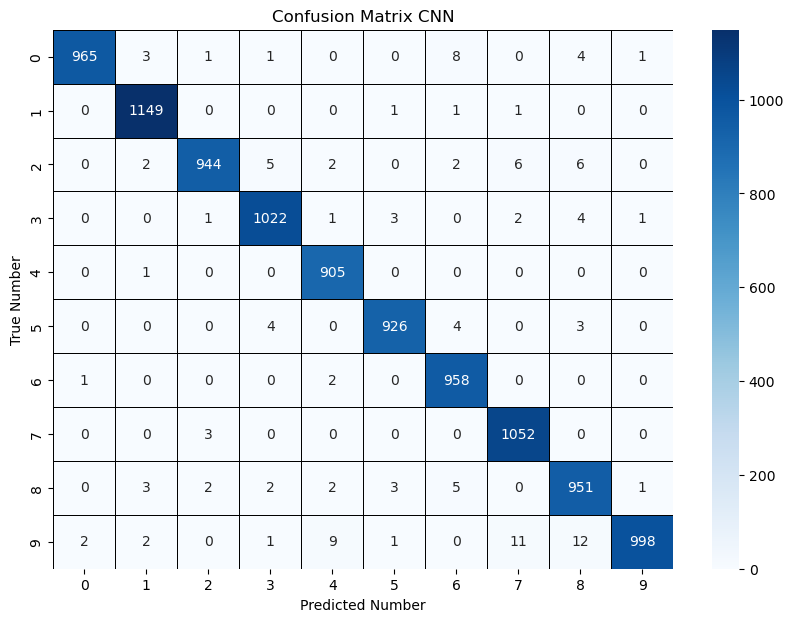

In [13]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cnn_model = tf.keras.models.load_model("cnn_model.v2.keras")

y_pred_probs = cnn_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1) 

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 7))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=range(10), 
    yticklabels=range(10), 
    linecolor='black',
    linewidths=0.5
)

plt.xlabel("Predicted Number")
plt.ylabel("True Number")
plt.title("Confusion Matrix CNN")
plt.show()
